In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from pymongo import MongoClient
import json

In [3]:
con = MongoClient('localhost',27017)
db = con.politica

In [2]:
dataset = pd.DataFrame()

In [4]:
text_tweets = []
for tweet in db.tweets_manuela.find():
    twitterText = ""
    if('retweeted_status' in tweet):
        if('extended_tweet' in tweet['retweeted_status']):
            twitterText = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
            twitterText = tweet['retweeted_status']['text']

    elif('extended_tweet' in tweet):
        twitterText = tweet['extended_tweet']['full_text']
    else:
        twitterText = tweet['text']
    
    text_tweets.append(twitterText)

dataset['text'] = pd.Series(text_tweets)

In [5]:
dataset['text_processed'] = np.nan # coluna que guardará os tweets processados

In [31]:
# download do pacote de preprocessamente para língua portuguesa
#nltk.download('rslp')

In [6]:
#Preprocessar as palavras
stemmer = nltk.stem.RSLPStemmer()
for ind, tweet in enumerate(dataset['text']):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
    t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)|#',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    
    # isolando o radical das palavras
    if len(t) > 0:
        t = t.split(' ')
        ste = [stemmer.stem(word) for word in t]
        processedTweet = ' '.join(ste)
        dataset['text_processed'][ind] = processedTweet
    else:
        dataset['text_processed'][ind] = ''

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
#Objetos para vetorizar e calcular as frequencias das palavras
count_vect = CountVectorizer()
tfidf = TfidfTransformer()

In [8]:
#Indexando as palavras do corpos
matrix_vectorized = count_vect.fit_transform(dataset['text_processed'].values.tolist())
matrix_vectorized.shape

(3773, 3287)

In [35]:
#Features da matrix
count_vect.get_feature_names()[0:10]

['aaa',
 'aaaaaaa',
 'aaaaaaaaaaaqaaaaaaaaaaqqqqqadhehsbhejajansbndnd',
 'aaaaaaaag',
 'ab',
 'abaix',
 'abandon',
 'abert',
 'abig',
 'abobr']

In [20]:
#Calculando o TF e o IDF das palavras de cada tweet
matrix_tfidf = tfidf.fit_transform(matrix_vectorized)

In [21]:
matrix_tfidf.shape

(3773, 3287)

## Clusterização com DBSCAN

In [9]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

In [10]:
#matrix_distances = cosine_distances(matrix_tfidf)
matrix_distances_cosine = cosine_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
matrix_distances_cosine.shape

(3773, 3773)

In [11]:
matrix_distances_euclidean = euclidean_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
matrix_distances_euclidean.shape

(3773, 3773)

In [12]:
print("Distância cosseno, máximo: ",matrix_distances_cosine.max())
print("Distância cosseno, média: ",matrix_distances_cosine.mean())
print("Distância cosseno, std: ",matrix_distances_cosine.std())
print("Distância cosseno, mínimo: ",matrix_distances_cosine.max())
print("-----------------------------------")
print("Distância euclidiana, máximo: ",matrix_distances_euclidean.max())
print("Distância euclidiana, média: ",matrix_distances_euclidean.mean())
print("Distância euclidiana, std: ",matrix_distances_euclidean.std())
print("Distância euclidiana, mínimo: ",matrix_distances_euclidean.std())

Distância cosseno, máximo:  1.0
Distância cosseno, média:  0.951017825534179
Distância cosseno, std:  0.15939335449203385
Distância cosseno, mínimo:  1.0
-----------------------------------
Distância euclidiana, máximo:  19.390719429665317
Distância euclidiana, média:  4.550658562538737
Distância euclidiana, std:  1.5486174686388592
Distância euclidiana, mínimo:  1.5486174686388592


#### Para determinar Eps e MinPoints ideais vamos utilizar as seguintes abordagens:
1. [A Dynamic Method for Discovering Density Varied Clusters](http://www.sersc.org/journals/IJSIP/vol6_no1/9.pdf)


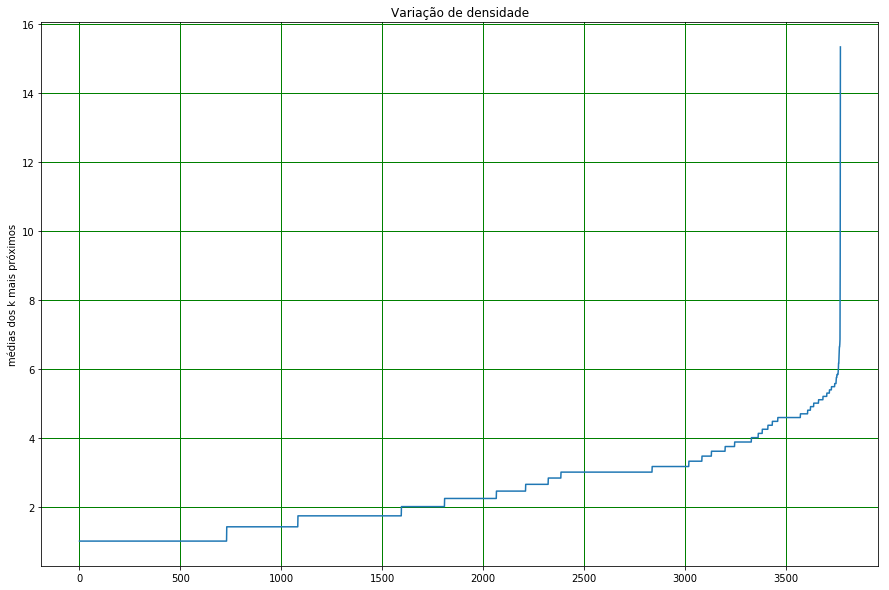

In [108]:
# ABORDAGEM 1
def k_dist(k, i, points):
    dist = []
    smaller = np.max(points)
    for i in range(0,k):
        for j in range(len(points)):
            if j != i:
                if points[j] < smaller and points[j] != 0:
                    smaller = points[j]
        dist.append(smaller)
    return np.mean(dist)

i = 0
y = []
while i < len(matrix_distances_euclidean):
    y.append(k_dist(3,i,matrix_distances_euclidean[i]))
    i += 1
y.sort()
    
plt.figure(figsize=(15,10))
plt.plot(y)
plt.grid(color='g', linestyle='-', linewidth=1)
plt.ylabel('médias dos k mais próximos')
plt.title('Variação de densidade')
plt.show()

In [13]:
# dbscan_cosine_distance = DBSCAN(eps=0.8, min_samples=30, metric="precomputed")
# clusters_cosine_dbscan = dbscan_cosine_distance.fit(matrix_distances_cosine)

minPoints = math.log(len(matrix_distances_euclidean))
dbscan_euclidean_distance = DBSCAN(eps=4.550658562538737, min_samples= minPoints, metric="precomputed")
clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)

#### Grid Search para Eps e MinPoints

In [65]:
eps = [4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0]
minpoints = range(8,24)

for e in eps:
    for m in minpoints:
        dbscan_euclidean_distance = DBSCAN(eps= e, min_samples= m, metric="precomputed")
        clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)
        
        if len(dataset['cluster_euclidean_dbscan'].value_counts()) >= 3:
            print('eps=',e,', minpoints=',m)

            #atribuindo identificador dos clusters
            dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

            #polaridade dos clusters
            print(dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum())
            print('-------------------------------------------------')

eps= 4.0 , minpoints= 8
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 9
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 10
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 11
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.0 , minpoints= 12
cluster_euclidean_dbscan
-1    -548.0
 0   -1515.0
 1   -3843.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float

eps= 4.2 , minpoints= 17
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 18
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 19
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 20
cluster_euclidean_dbscan
-1    -599.0
 0   -1515.0
 1   -3890.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 21
cluster_euclidean_dbscan
-1    -659.0
 0   -1515.0
 1   -3890.0
 2    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.2 , minpoints= 2

eps= 4.5 , minpoints= 11
cluster_euclidean_dbscan
-1    -424.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 12
cluster_euclidean_dbscan
-1    -424.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 13
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 14
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
-------------------------------------------------
eps= 4.5 , minpoints= 15
cluster_euclidean_dbscan
-1    -522.0
 0   -1515.0
 1   -3967.0
 2     -60.0
 3    -450.0
Name: polaridade, dtype: float64
----------------------------------

In [14]:
# dataset['cluster_cosine_dbscan'] = clusters_cosine_dbscan.labels_
dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

In [39]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,polaridade
0,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,-5.0
1,"@manudeputada @PCdoB_Oficial ""Malevolente amor...",malevol am é tud é redenç sorris humilh dren v...,1,-3.0
2,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,-5.0
3,Eu e a namo levemente apaixonadas pela deputad...,nam lev apaixon deput fal sal aul conheç favor,1,-1.0
4,@JoselitoMuller3 @manudeputada hmm esse cabeli...,hmm cabel ócul falt dent frent parec nunc com ...,1,2.0


## Clusterização com K-means

In [44]:
#from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

In [70]:
matrix_distances = cosine_distances(matrix_tfidf)
matrix_distances.shape

(3773, 3773)

In [45]:
#matrix_distances_euclidean = euclidean_distances(matrix_tfidf)
matrix_distances_euclidean = euclidean_distances(matrix_vectorized) #computando distâncias representação vetorial sem tf-idf
matrix_distances_euclidean.shape

(3773, 3773)

In [46]:
kmeans_cosine_distance = KMeans(n_clusters=3, precompute_distances=True)
clusters_cosine_kmeans = kmeans_cosine_distance.fit(matrix_distances)

kmeans_euclidean_distance = KMeans(n_clusters=3, precompute_distances=True)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_distances_euclidean)

In [47]:
dataset['cluster_cosine_kmeans'] = clusters_cosine_kmeans.labels_
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

## Plot dos clusters do DBScan

In [48]:
import matplotlib.pyplot as plt

In [65]:
dataset['cluster_cosine_dbscan'].value_counts()

0    3773
Name: cluster_cosine_dbscan, dtype: int64

In [64]:
dataset['cluster_euclidean_dbscan'].value_counts()

 1    3150
 0     303
-1     213
 3      75
 2      20
 4      12
Name: cluster_euclidean_dbscan, dtype: int64

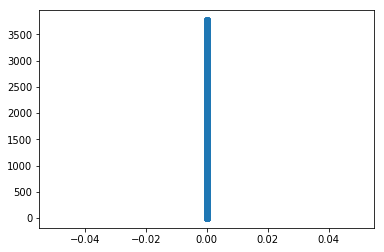

In [67]:
x = dataset['cluster_cosine_dbscan'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

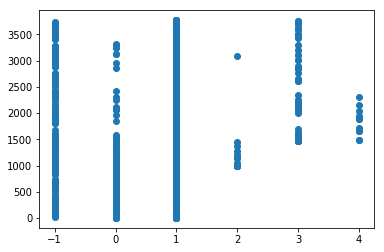

In [17]:
x = dataset['cluster_euclidean_dbscan'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

## Plot dos clusters do KMeans

In [49]:
dataset['cluster_cosine_kmeans'].value_counts()

1    3135
2     335
0     303
Name: cluster_cosine_kmeans, dtype: int64

In [50]:
dataset['cluster_euclidean_kmeans'].value_counts()

0    2277
1    1193
2     303
Name: cluster_euclidean_kmeans, dtype: int64

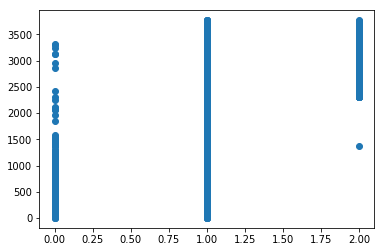

In [51]:
x = dataset['cluster_cosine_kmeans'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

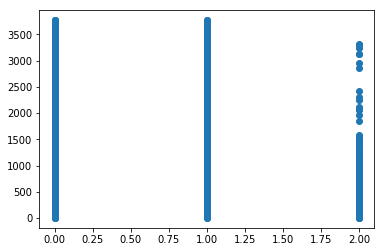

In [52]:
x = dataset['cluster_euclidean_kmeans'].values
y = range(len(dataset['text'].values))
plt.plot(x, y, "o")
plt.show()

## Calculando polaridade dos tweets

In [21]:
base_lexica = pd.read_csv('SEMANTICSCLASSIFICATION/SentiLex-PT01/SentiLex-flex-PT01.txt', sep=';')
base_lexica.columns = ['palavra','gn','tg','pol','anot']

In [22]:
base_lexica['pos'] = np.nan

In [23]:
i = 0
for p in base_lexica.palavra:
    line = p.split('.')
    base_lexica.palavra[i] = line[0]
    base_lexica.pos[i] = line[1]
    i += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
dataset['polaridade'] = 0

In [25]:
base_lexica.head()

,palavra,gn,tg,pol,anot,pos
0,"abafadas,abafado",GN=fp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
1,"abafado,abafado",GN=ms,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
2,"abafados,abafado",GN=mp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
3,"abafante,abafante",GN=fs,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj
4,"abafante,abafante",GN=ms,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj


In [54]:
def preProcessor(tweet):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
#     t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    return t

In [34]:
def searchWord(word):
    k = 0
    for p in base_lexica.palavra:
        if word in p:
            return int(base_lexica.pol[k].split('=')[1])
        k += 1
    return 0

In [35]:
j = 0
for tweet in dataset.text:
    twt = preProcessor(tweet)
    score = 0
    for p in twt.split(' '):
        score += searchWord(p)
    dataset.polaridade[j] = score
    j += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [38]:
dataset.to_csv('manuela_clusterizado.csv',';',encoding='utf-8', index=False)

## Análise dos clusters do DBScan

In [27]:
df = pd.read_csv('manuela_clusterizado.csv',sep=';',encoding='utf-8')

In [28]:
dataset['polaridade'] = df.polaridade

In [36]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,polaridade
0,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,-5.0
1,"@manudeputada @PCdoB_Oficial ""Malevolente amor...",malevol am é tud é redenç sorris humilh dren v...,1,-3.0
2,"A pergunta é séria, @manudeputada: quer me pag...",pergunt é sér qu pag log fic dev process senh ...,0,-5.0
3,Eu e a namo levemente apaixonadas pela deputad...,nam lev apaixon deput fal sal aul conheç favor,1,-1.0
4,@JoselitoMuller3 @manudeputada hmm esse cabeli...,hmm cabel ócul falt dent frent parec nunc com ...,1,2.0


In [69]:
dataset.groupby('cluster_cosine_dbscan')['polaridade'].sum()

cluster_cosine_dbscan
0   -6509.0
Name: polaridade, dtype: float64

In [37]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum()

cluster_euclidean_dbscan
-1    -445.0
 0   -1515.0
 1   -3946.0
 2     -60.0
 3    -450.0
 4     -98.0
Name: polaridade, dtype: float64

In [ ]:
dataset['polaridade'] = df.polaridade
dataset.groupby('cluster_cosine_kmeans')['polaridade'].sum()

In [56]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].sum()

cluster_euclidean_dbscan
-1   -3199.0
 0   -1466.0
 1    -196.0
 2    -715.0
 3    -170.0
 4    -147.0
 5    -616.0
Name: polaridade, dtype: float64

In [82]:
pos = 0
neg = 0
neu = 0
#for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == 2].index].values:
for v in dataset.polaridade.values:
    if v < 0:
        neg += 1
    if v > 0:
        pos += 1
    if v == 0:
        neu += 1

print(pos)
print(neg)
print(neu)

458
2589
723


> #### K-means with only CountVectorized

Tipo de distância| Cluster 0| Cluster 1| Cluster2
-----------------|---------------|--------------|---------------
Distância cosseno|pos = 0; neg = 299; neu = 4| pos = 434; neg = 2049; neu = 649|pos = 24; neg = 241; neu = 70
Distância euclidiana|pos = 319; neg = 1397; neu = 560| pos = 139; neg = 893; neu = 159|pos = 0; neg = 299; neu = 4


In [24]:
import SEMANTICSCLASSIFICATION.semanticsClassification as sc

In [7]:
sc.termScoreSummationMethod(df.text[7])

0

### Recalculando a polaridade

In [10]:
df['polaridade_sentilex'] = 0

In [12]:
i = 0
for tweet in df.text:
    df.polaridade_sentilex[i] = sc.termScoreSummationMethod(tweet)
    i += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df.polaridade_sentilex[df.polaridade_sentilex < 0]

Series([], Name: polaridade_sentilex, dtype: int64)

In [25]:
sc.termScoreSummationMethod("ruim horrível péssimo")

0

In [57]:
ifeel = pd.DataFrame()
ifeel['text'] = dataset.text[0:298]

j = 0
for i in ifeel.text:
    ifeel.text[j] = preProcessor(i)
    j += 1
    
ifeel.to_csv('ifeel_test.csv', sep=';',index=False)